In [1]:
!python3 --version
import numpy as np
import arviz as az
import tensorrt
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

tfd = tfp.distributions
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Python 3.10.6


2023-05-10 15:58:45.999864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 15:58:47.488363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 15:58:47.488444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0e:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 15:58:47.503631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been bu

Num GPUs Available:  2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


# **Grid Approximation**

In [3]:
#from tensorflow.python.ops.gen_array_ops import concat
# define grid
n_points = 1000  # change to an odd number for Code 2.5 graphs to
# match book examples in Figure 2.6
p_grid = tf.linspace(start=0.0, stop=1.0, num=n_points)

# define prior
prior = tf.ones([n_points])

# compute likelihood at each value in grid
likelihood = tfd.Binomial(total_count=9, probs=p_grid).prob(6)  #6 water out of 9 tosses.

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / tf.reduce_sum(unstd_posterior)

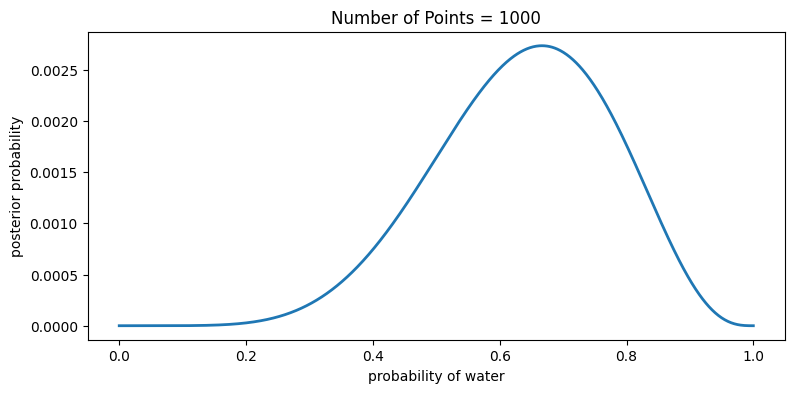

In [4]:
# Plotting
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(p_grid, posterior, "-", linewidth=2.0, markersize = 3)
ax.set(xlabel="probability of water", ylabel="posterior probability", title="Number of Points = "+str(n_points));

# **Sampling**

0.15115115
970


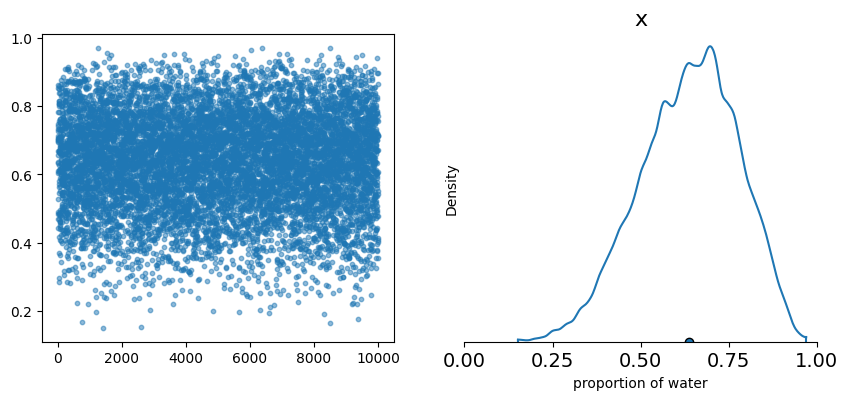

In [5]:
# Sampling
samples_index = tfd.Categorical(probs=posterior).sample(10000)
samples = p_grid.numpy()[samples_index]
print(p_grid.numpy()[tf.reduce_min(samples_index)])
print(tf.reduce_max(samples_index).numpy())
fig, ax = plt.subplots(1,2, figsize=(10, 4))
ax[0].scatter(range(len(samples)),samples, s = 10, alpha = 0.5)
az.plot_density(samples, hdi_prob = 1, ax = ax[1])
ax[1].set(xlabel="proportion of water", ylabel="Density")
ax[1].set_xticks([0,0.25,0.5,0.75,1])
ax[1].axis([0, 1, 0,3])
plt.show()

In [6]:
# Posterior probability that the proportion of water is less than 0.5
print(tf.reduce_sum(posterior[p_grid<0.5]).numpy())
print(np.sum(samples<0.5)/1e4)
print(np.sum((samples>0.5) & (samples<0.75))/1e4)
print(np.percentile(samples, 80)) # 80% percentile
print(np.percentile(samples, [10, 90])) # Percentile Interval (PI)

0.17187457
0.1715
0.6078
0.7597597241401672
[0.44644645 0.81381381]


## **Skewed posterior** and HPDI

[0.8378378 0.998999 ]


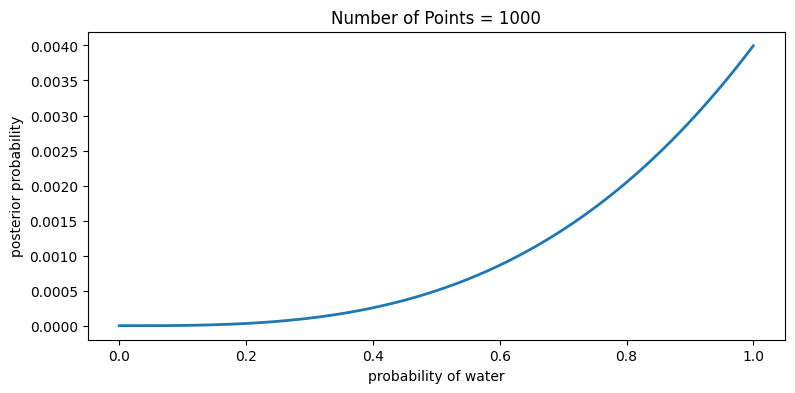

In [7]:
n_points = 1000  # change to an odd number for Code 2.5 graphs to
p_grid = tf.linspace(start=0.0, stop=1.0, num=n_points)

# define prior
prior = tf.ones([n_points])

# compute likelihood at each value in grid
likelihood = tfd.Binomial(total_count=3, probs=p_grid).prob(3)  #6 water out of 9 tosses.

# compute product of likelihood and prior
unstd_posterior = likelihood*prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / tf.reduce_sum(unstd_posterior)
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(p_grid, posterior, "-", linewidth=2.0, markersize = 3)
ax.set(xlabel="probability of water", ylabel="posterior probability", title="Number of Points = "+str(n_points))
# Sampling
samples = p_grid.numpy()[tfd.Categorical(probs=posterior).sample(1e4)]

print(az.hdi(samples, hdi_prob=0.5))  # HPDI

**Loss Function**

In [8]:
loss = list(map(lambda d: tf.reduce_sum(posterior * np.abs(d - p_grid)), p_grid))
tf.print(p_grid[tf.math.argmin(loss)])

0.840840816


# **Simulate Prediction**

In [9]:
# Probability of water = 0, 1, or 2, in 2 tosses
tf.print(list(map(lambda W: tfd.Binomial(total_count=2, probs=0.7).prob(W), np.array([0,1,2]))))

[0.0899999961, 0.420000345, 0.49]


In [10]:
# 1 sample from probability of W in 2 tosses (Assuming the proportion of water is 0.7)
tf.print(tfd.Binomial(total_count=2, probs=0.7).sample())
# 10 sample from probability of W in 2 tosses
tf.print(tfd.Binomial(total_count=2, probs=0.7).sample(10))
dummy_w = tfd.Binomial(total_count=2, probs=0.7).sample(1e5)
W, W_count = np.unique(dummy_w.numpy(), return_counts=True)
print(W,'\n', W_count/1e5)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-05-10 15:59:52.113302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-05-10 15:59:52.122711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'binomial_noncpu/while/uniform/stateless_random_uniform/StatelessRandomUniformV2/binomial_noncpu/concat' with dtype int32 and shape [1]
	 [[{{node binomial_noncpu/while/uniform/stateless_random_uniform/StatelessRandomUniformV2/binomial_noncpu/concat}}]]
2023-05-10 15:59:52.122823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an err

1
[2 0 1 ... 2 0 1]
[0. 1. 2.] 
 [0.09054 0.42008 0.48938]


/tmp/ipykernel_3354/1127628088.py:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax.stem(W, W_count, use_line_collection = True)


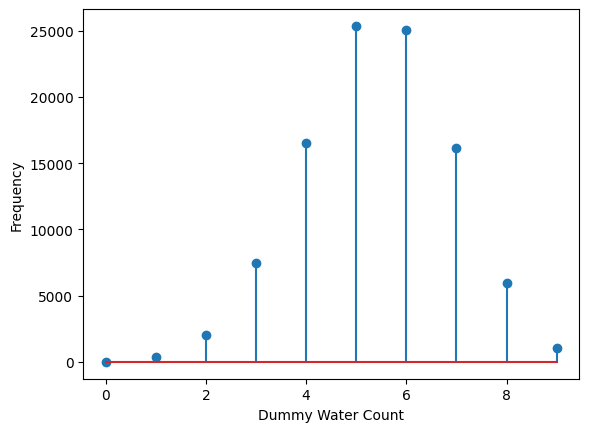

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] 
 [0.0003  0.00347 0.02047 0.07479 0.16513 0.25366 0.25045 0.16138 0.0599
 0.01045]


In [11]:
# Same as above but with 9 tosses
dummy_w = tfd.Binomial(total_count=9, probs=0.6).sample(1e5)
W, W_count = np.unique(dummy_w.numpy(), return_counts=True)
fig, ax = plt.subplots()
ax.stem(W, W_count, use_line_collection = True)
ax.set(xlabel="Dummy Water Count", ylabel="Frequency")
plt.show()
# OR  ax.hist(dummy_w.numpy())
print(W,'\n', W_count/1e5)

### **Posterior Predictive Distribution**

2023-05-10 16:00:01.188792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-05-10 16:00:01.196885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'binomial_noncpu/while/uniform/stateless_random_uniform/StatelessRandomUniformV2/binomial_noncpu/concat' with dtype int32 and shape [2]
	 [[{{node binomial_noncpu/while/uniform/stateless_random_uniform/StatelessRandomUniformV2/binomial_noncpu/concat}}]]
2023-05-10 16:00:01.196994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an err

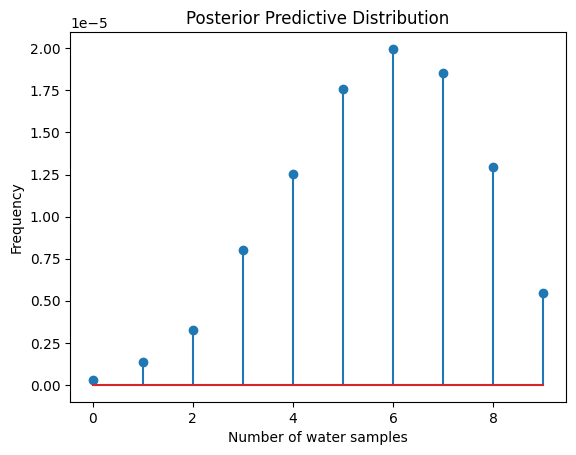

In [12]:
# Calculating Posterior
n_points = 1000  # change to an odd number for Code 2.5 graphs to
p_grid = tf.linspace(start=0.0, stop=1.0, num=n_points)
prior = tf.ones([n_points])
likelihood = tfd.Binomial(total_count=9, probs=p_grid).prob(6)  #6 water out of 9 tosses.
unstd_posterior = likelihood*prior
posterior = unstd_posterior / tf.reduce_sum(unstd_posterior)
posterior_samples = p_grid.numpy()[tfd.Categorical(probs=posterior).sample(1e4)]

# Calculating Posterior Predictive Distribution
dummy_w = tfd.Binomial(total_count=9, probs=posterior_samples).sample()
W, W_count = np.unique(dummy_w.numpy(), return_counts=True)
W_count = W_count/1e8
fig, ax = plt.subplots()
ax.stem(W, W_count, use_line_collection = True)
ax.set(xlabel= "Number of water samples", ylabel="Frequency", title = "Posterior Predictive Distribution")
plt.show()